## Saliency Maps

In [1]:
import torch
import pickle
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.eval()

/Users/ashutosh1919/miniforge3/envs/cnn_xai/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /Users/ashutosh1919/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [3]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "./data/dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [4]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

In [5]:
input_batch.shape

torch.Size([1, 3, 224, 224])

In [6]:
input_batch = input_batch.to(device)
input_batch.requires_grad_()

tensor([[[[-1.9295, -1.9295, -1.9124,  ..., -2.0323, -1.9467, -1.9295],
          [-1.9980, -1.8953, -1.9124,  ..., -1.9638, -1.9295, -1.7754],
          [-1.9980, -1.9467, -1.9124,  ..., -2.0494, -1.9638, -1.8953],
          ...,
          [-1.4843, -1.6042, -1.6213,  ..., -0.8678, -1.1075, -1.0733],
          [-1.5357, -1.6042, -1.6213,  ..., -1.0390, -1.6213, -1.4500],
          [-1.5528, -1.4843, -1.2445,  ..., -0.9192, -1.2788, -1.2617]],

         [[-1.8256, -1.8256, -1.8081,  ..., -1.9832, -1.9132, -1.9132],
          [-1.8256, -1.8431, -1.8431,  ..., -1.9657, -1.9307, -1.8782],
          [-1.8256, -1.8431, -1.8606,  ..., -1.9657, -1.9482, -1.9132],
          ...,
          [-0.9853, -0.9678, -0.9853,  ..., -0.4601, -0.6352, -0.6702],
          [-0.9853, -0.9853, -1.0028,  ..., -0.5651, -1.1253, -0.8978],
          [-0.9503, -0.9853, -0.8102,  ..., -0.3901, -0.8102, -0.7402]],

         [[-1.6127, -1.5953, -1.5604,  ..., -1.7173, -1.6999, -1.7173],
          [-1.6650, -1.6302, -

In [7]:
# Retrieve output from the image
output = model(input_batch)

# Catch the output
output_idx = output.argmax()
output_max = output[0, output_idx]

# Do backpropagation to get the derivative of the output based on the image
output_max.backward()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


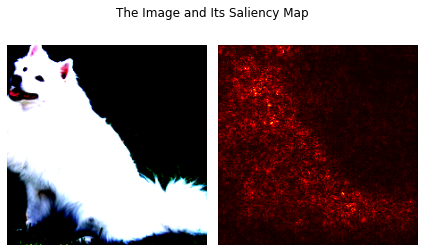

In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

saliency, _ = torch.max(input_batch.grad.data.abs(), dim=1) 
saliency = saliency.reshape(224, 224)

# Reshape the image
image = input_batch.reshape(-1, 224, 224)

# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
ax[0].axis('off')
ax[1].imshow(saliency.cpu(), cmap='hot')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle('The Image and Its Saliency Map')
plt.show()

In [9]:
from explainable_cnn.explainers import CNNExplainer

In [10]:
with open("./data/imagenet_class_labels.pkl", "rb") as label_file:
    imagenet_class_labels = pickle.load(label_file)

In [11]:
x_cnn = CNNExplainer(model, imagenet_class_labels)

In [12]:
img = x_cnn.get_saliency_map("./data/images/tiger_shark.jpeg", (224, 224))

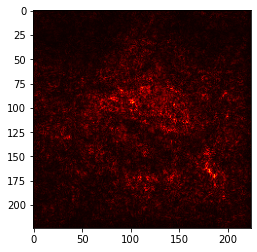

In [ ]:
plt.imshow(img, cmap='hot')

In [ ]:
x_cnn.get_occlusion_sensitivity("./data/images/tiger_shark.jpeg", 3, (224, 224))

AssertionError: Padding length too large

## Grad CAM

In [12]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = datasets.ImageFolder(root='./data/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)